In [1]:
!pip install --upgrade tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers

import warnings

![](https://user-images.githubusercontent.com/39909903/91180489-9fe39400-e69c-11ea-9968-9adf6741d595.jpg)

# <center>😀😐😭 Speech Emotion Detection 😭😐😀</center>

# Loading Data

In [3]:
image_dir = Path('../input/speech-emotion-recognition-en/Crema')

In [4]:
filepaths = list(image_dir.glob(r'**/*.wav'))

In [5]:
labels = list(map(lambda x: os.path.split(x)[1].split('_')[2], filepaths))

In [6]:
set(labels)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

These correspond to the emotions:

* ANG: Anger 😡
* DIS: Disgust 🤢
* FEA: Fear 😱
* HAP: Happiness 😀
* NEU: Neutral 😐
* SAD: Sadness 😭

In [7]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

audio_df = pd.concat([filepaths, labels], axis=1)
audio_df

,Filepath,Label
0,../input/speech-emotion-recognition-en/Crema/1...,DIS
1,../input/speech-emotion-recognition-en/Crema/1...,HAP
2,../input/speech-emotion-recognition-en/Crema/1...,HAP
3,../input/speech-emotion-recognition-en/Crema/1...,DIS
4,../input/speech-emotion-recognition-en/Crema/1...,DIS
...,...,...
7437,../input/speech-emotion-recognition-en/Crema/1...,ANG
7438,../input/speech-emotion-recognition-en/Crema/1...,ANG
7439,../input/speech-emotion-recognition-en/Crema/1...,ANG
7440,../input/speech-emotion-recognition-en/Crema/1...,SAD


#  Visualising Data

<Axes: xlabel='Label', ylabel='Count'>

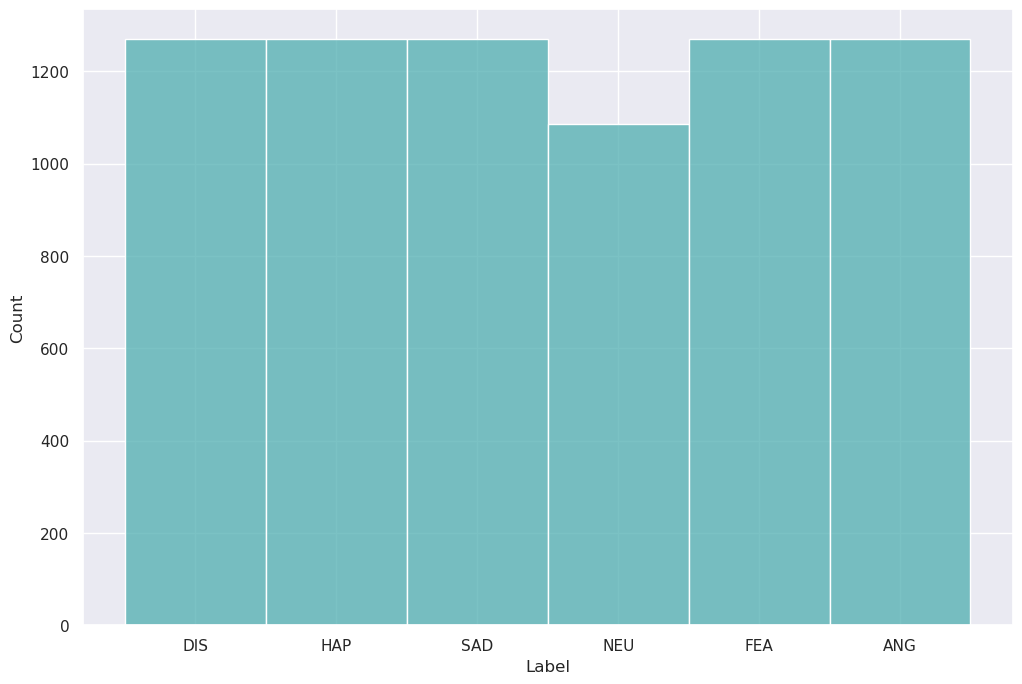

In [8]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')
sns.histplot(labels, color='#4FAEB0')

In [9]:
audio_arrays = []

for i in audio_df['Filepath']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
audio_df['Arrays'] = audio_arrays

In [10]:
audio_df

,Filepath,Label,Arrays
0,../input/speech-emotion-recognition-en/Crema/1...,DIS,"[0.0051987115, 0.0067456197, 0.0065078777, 0.0..."
1,../input/speech-emotion-recognition-en/Crema/1...,HAP,"[-0.0054751206, -0.00713885, -0.0067585437, -0..."
2,../input/speech-emotion-recognition-en/Crema/1...,HAP,"[-2.10721e-05, 0.00013225194, 0.00036462393, 0..."
3,../input/speech-emotion-recognition-en/Crema/1...,DIS,"[0.0027296818, 0.0025122813, 0.0009894323, 4.4..."
4,../input/speech-emotion-recognition-en/Crema/1...,DIS,"[-0.0012989982, -0.0016537481, -0.0013569102, ..."
...,...,...,...
7437,../input/speech-emotion-recognition-en/Crema/1...,ANG,"[0.006019091, 0.0075440574, 0.006769056, 0.006..."
7438,../input/speech-emotion-recognition-en/Crema/1...,ANG,"[-0.00096016855, -0.001384086, -0.0015201073, ..."
7439,../input/speech-emotion-recognition-en/Crema/1...,ANG,"[0.0013364321, 0.0017082326, 0.0018099947, 0.0..."
7440,../input/speech-emotion-recognition-en/Crema/1...,SAD,"[0.0010454531, 0.0015660033, 0.0015824048, 0.0..."


## <h2><span class="label label-default" style="background-color:#C00808; color:white;">💥 ANGER 💥</span></h2>

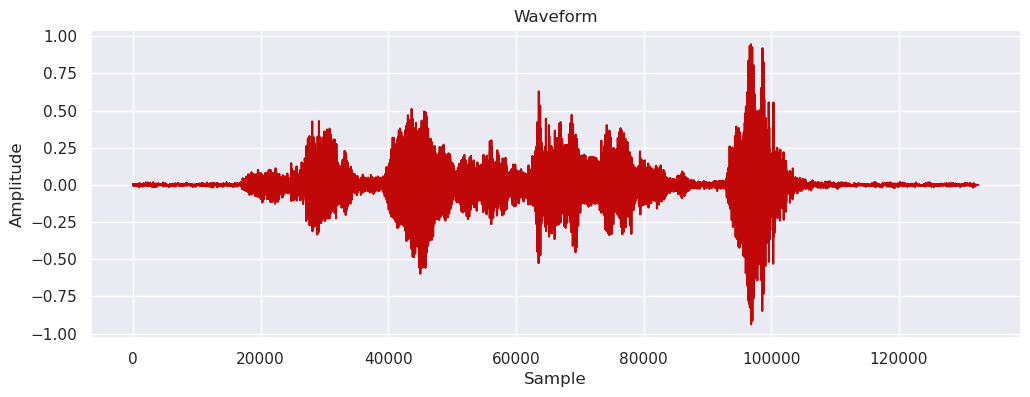

In [11]:
angfile = audio_df[audio_df['Label'] == 'ANG']['Filepath']
angarray = audio_df[audio_df['Label'] == 'ANG']['Arrays']

plt.figure(figsize=(12, 4))
plt.plot(angarray.iloc[0], color='#C00808')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

IPython.display.Audio(angfile.iloc[0])


## <h2><span class="label label-default" style="background-color:#804E2D; color:white;"> 🤢 DISGUST 🤢 </span></h2>

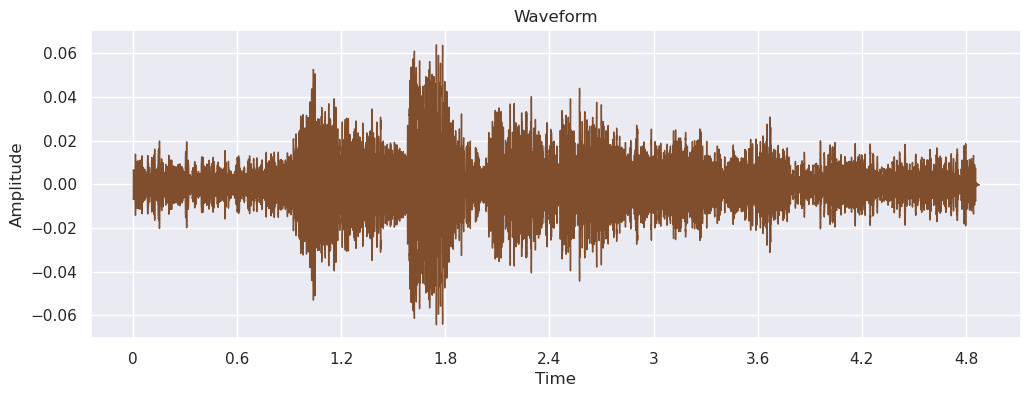

In [12]:
disfile = audio_df[audio_df['Label'] == 'DIS']['Filepath']
disarray = audio_df[audio_df['Label'] == 'DIS']['Arrays']

plt.figure(figsize=(12, 4))
librosa.display.waveshow(disarray.iloc[0], color='#804E2D')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

IPython.display.Audio(disfile.iloc[0])

## <h2><span class="label label-default" style="background-color:#7D55AA; color:white; "> 👻 FEAR 👻 </span></h2>

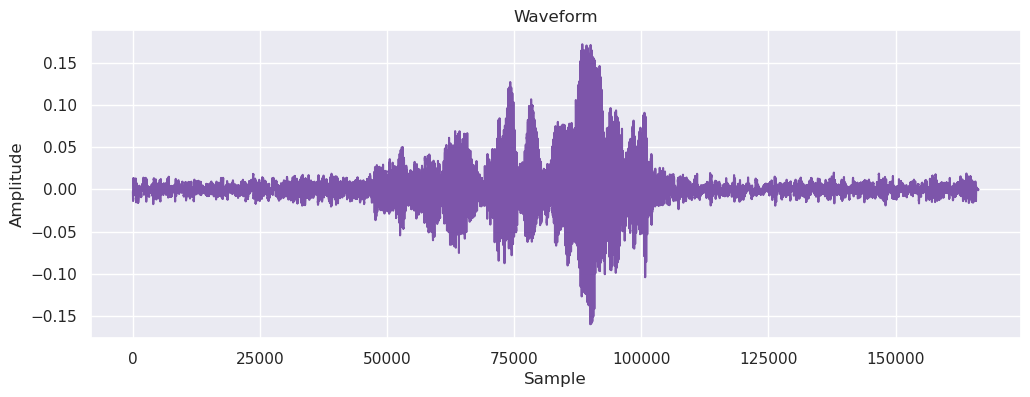

In [13]:
feafile = audio_df[audio_df['Label'] == 'FEA']['Filepath']
feaarray = audio_df[audio_df['Label'] == 'FEA']['Arrays']

plt.figure(figsize=(12, 4))
plt.plot(feaarray.iloc[0], color='#7D55AA')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

IPython.display.Audio(feafile.iloc[0])

## <h2><span class="label label-default" style="background-color:#4CB847; color:white;"> 😐 NEUTRAL 😐 </span></h2>

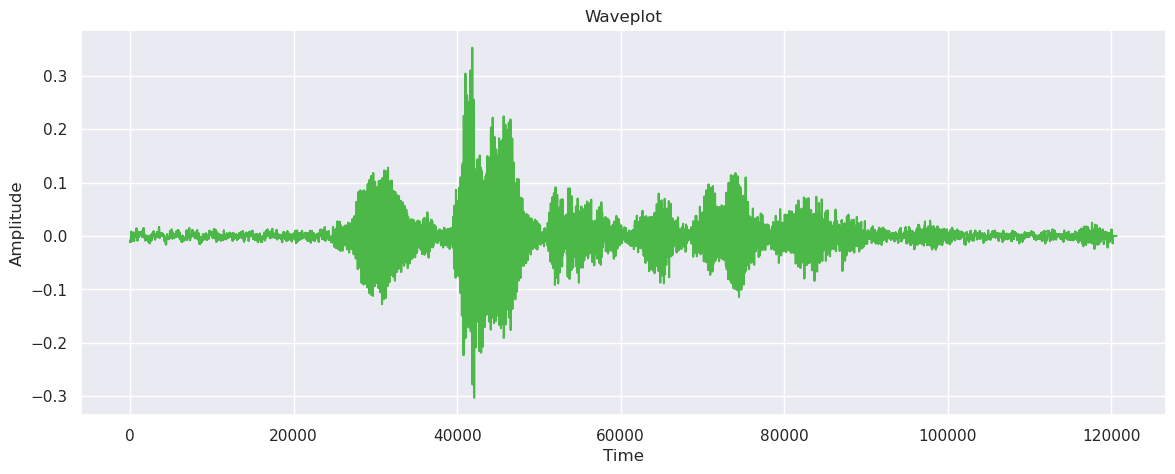

In [14]:

neuarray = audio_df[audio_df['Label'] == 'NEU']['Arrays']

plt.figure(figsize=(14, 5))
plt.plot(neuarray.iloc[0], color='#4CB847')
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()




## <h2><span class="label label-default" style="background-color:#478FB8; color:white;"> ☔ SADNESS ☔ </span></h2>

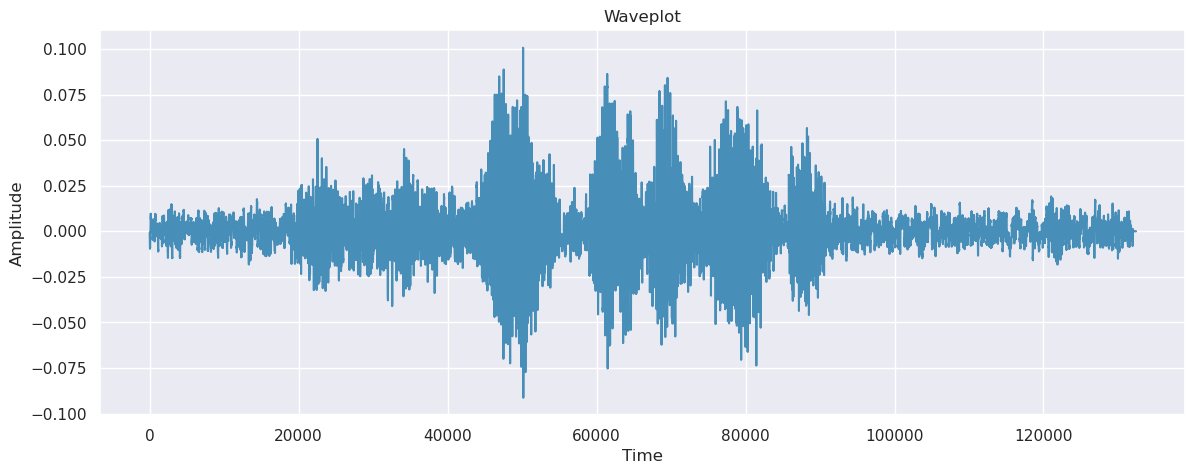

In [15]:
sadarray = audio_df[audio_df['Label'] == 'SAD']['Arrays']

plt.figure(figsize=(14, 5))
plt.plot(sadarray.iloc[0], color='#478FB8')
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Data Augmentation

In [16]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# Extracting Features

In [17]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))     

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))
    
    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, tonnetz))
    
    return result


In [18]:
def get_features(data):
    result = []
    
    # without augmentation
    res1 = extract_features(data)
    result.append(res1)
    
    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result.append(res2)
    
    # with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sr)
    res3 = extract_features(data_stretch_pitch)
    result.append(res3)
    
    return result

In [19]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


<center> <h1>Thank you</h1> </center>